# DESAFIO COMPLEMENTARIO 1: Evaluando modelos ML

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('bmh')

## DATASET: COVID 19 Progreso mundial de vacunación

El set de datos incluye información acerca de las vacunaciones por COVID desde Diciembre de 2020 a Marzo de 2022. Se analizó la relación que existen entre el País, fecha, cantidad de personas vacunadas, vacunaciones diarias, personas con esquema completo.

In [2]:
data = pd.read_csv('../datasets/covid_vaccinations/country_vaccinations.csv')
data.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/


In [3]:
# Convertir DATE a formato fecha
data['date'] = pd.to_datetime(data['date'])

## FEATURE ENGINEERING

### Posibles outliers

Es posible que, en este caso, los valores sean nulos o NaN, ya que el dataset esta separado por días y en esos casos puede haberse no llevado a cabo la vacunación. Pero los vamos a eliminar ya que no aportan a nuestro modelo.

In [4]:
# Eliminar valores NaN de people_vaccinated
data = data[data['people_vaccinated'].notna()]

# Eliminar valores 0.0 de people_vaccinated
data = data.loc[data['people_vaccinated'] != 0.0]

data.head()

,country,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines,source_name,source_website
6,Afghanistan,AFG,2021-02-28,8200.0,8200.0,NaN,NaN,1367.0,0.02,0.02,NaN,34.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
22,Afghanistan,AFG,2021-03-16,54000.0,54000.0,NaN,NaN,2862.0,0.14,0.14,NaN,72.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
44,Afghanistan,AFG,2021-04-07,120000.0,120000.0,NaN,NaN,3000.0,0.30,0.30,NaN,75.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
59,Afghanistan,AFG,2021-04-22,240000.0,240000.0,NaN,NaN,8000.0,0.60,0.60,NaN,201.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/
78,Afghanistan,AFG,2021-05-11,504502.0,448878.0,55624.0,NaN,13921.0,1.27,1.13,0.14,349.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi...",World Health Organization,https://covid19.who.int/


## Modelo

In [5]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series

In [6]:
# Agrupar por día
period = data.groupby(data['date'].dt.to_period('D')).sum()

In [7]:
y = pd.Series(period['people_vaccinated'].values, index=period.index)
print('Tamaño de y: ', y.shape[0])

Tamaño de y:  479


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

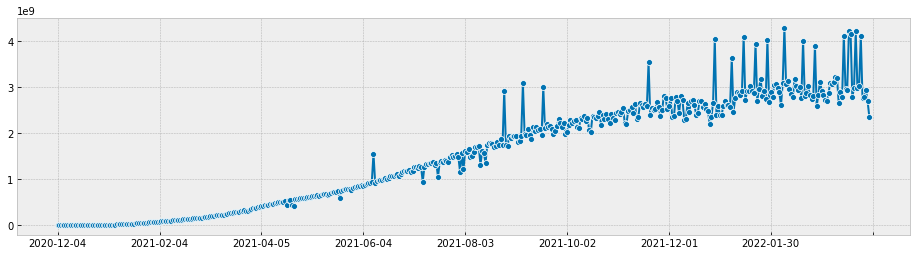

In [8]:
plot_series(y)

In [9]:
y_train, y_test = temporal_train_test_split(y, test_size=0.2)
print('Train: ', y_train.shape[0], '- Test: ', y_test.shape[0])

Train:  383 - Test:  96


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

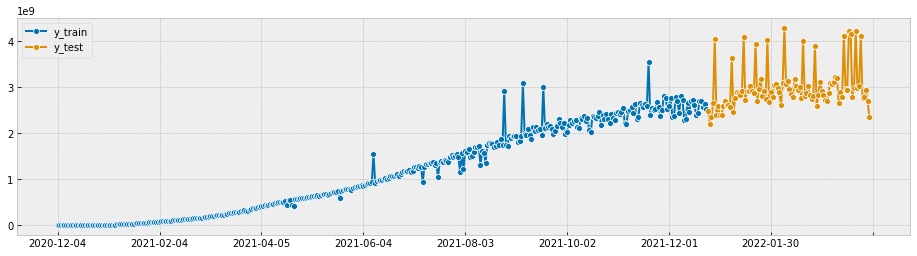

In [10]:
plot_series(y_train, y_test, labels=['y_train', 'y_test'])

In [11]:
# Crear modelo para pronosticar y_test desde y_train
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = ThetaForecaster(sp=24)
forecaster.fit(y_train, fh=fh)

# Predicciones
y_pred = forecaster.predict(fh)

C:\Users\alk10\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Text(0, 0.5, 'Personas vacunadas [millones]')

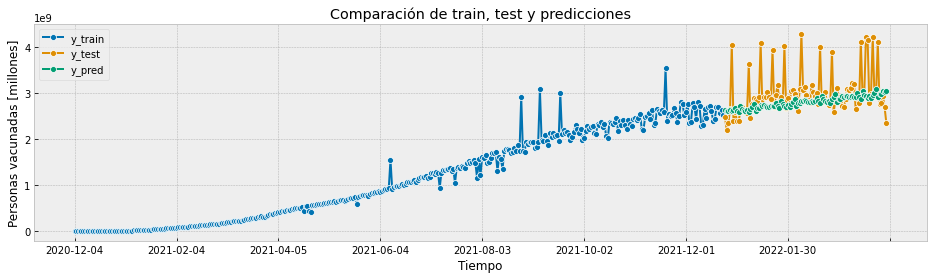

In [12]:
# Grafica de data y predicciones
fig, ax = plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.set_title('Comparación de train, test y predicciones')
ax.set_xlabel('Tiempo')
ax.set_ylabel('Personas vacunadas [millones]')

### Métricas y Evaluación

In [13]:
# Error absoluto medio (MAE)
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

0.09090243298173574

Ya que el MEA es el promedio de la diferencia entre el valor pronosticado y el valor real en cada punto que se pronostica, se concidera que a menor valor mejor se adapta el modelo.

In [14]:
# Crear modelo para pronosticar y_train
fh2 = ForecastingHorizon(y_train.index, is_relative=False)
y_pred2 = forecaster.predict(fh2)

In [15]:
mean_absolute_percentage_error(y_train, y_pred2)

8619467.963773763

### Probando otros algoritmos

In [16]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

In [17]:
fh_exp = ForecastingHorizon(y_test.index, is_relative=False)
forecaster_exp = ExponentialSmoothing(trend='add', seasonal='multiplicative', sp=12)
forecaster_exp.fit(y_train)

y_pred_exp = forecaster.predict(fh_exp)

C:\Users\alk10\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [18]:
mean_absolute_percentage_error(y_test, y_pred_exp)

0.09090243298173574

In [19]:
fh_exp2 = ForecastingHorizon(y_train.index, is_relative=False)
y_pred_exp2 = forecaster.predict(fh_exp2)

In [20]:
mean_absolute_percentage_error(y_train, y_pred_exp2)

8619467.963773763

Al utilizar otro algoritmo, la diferencia disminuye, pero sigue siendo significativa

#### Estudiamos la diferencia

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

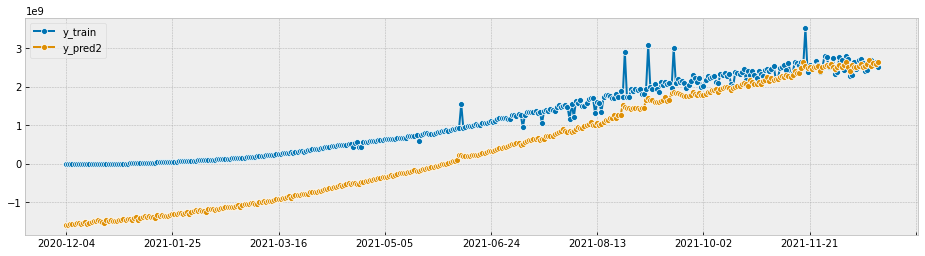

In [21]:
# Grafica de y_train y y_pred2
plot_series(y_train, y_pred2, labels=['y_train', 'y_pred2'])

In [22]:
fh2 = ForecastingHorizon(y_train.loc['2021-10-01':].index, is_relative=False)
y_pred2 = forecaster.predict(fh2)

In [23]:
mean_absolute_percentage_error(y_train.loc['2021-10-01':], y_pred2)

0.08269335342570872

In [24]:
mean_absolute_percentage_error(y_test, y_pred)

0.09090243298173574

Al omitir los primeros datos del dataset train, el MEA es más parecido al de test, ya que al inicio de y_train el margen de error es muy grande, porque no tiene datos previos para contrastar.